In [26]:
# KerasTuner를 설치

!pip install keras-tuner

# 필요한 라이브러리 불러오기

import tensorflow as tf                            # 딥러닝 모델을 쉽게 구축하고 학습하는 라이브러리
import keras                                       # 딥러닝 모델을 쉽게 구축하고 학습하는 라이브러리
import keras_tuner as kt                           # Keras Tuner는 모델 하이퍼파라미터 튜닝을 위한 도구 제공
from sklearn.model_selection import train_test_split  # train_test_split 함수는 데이터를 학습용과 테스트용으로 나누는데 사용
import os

In [27]:
# keras에 내장되어 있는 datasets으로 데이터셋은 MNIST 불러오기
# => 학습용 데이터(x_train, y_train), 테스트용 데이터(x_test, y_test)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print("x_train.shape:", x_train.shape)  # cifar10 데이터셋은 32x32 크기의 컬러 이미지로 구성
print("y_train.shape:", y_train.shape)
print("x_test.shape:", x_test.shape)
print("y_test.shape",y_test.shape)

x_train.shape: (50000, 32, 32, 3)
y_train.shape: (50000, 1)
x_test.shape: (10000, 32, 32, 3)
y_test.shape (10000, 1)


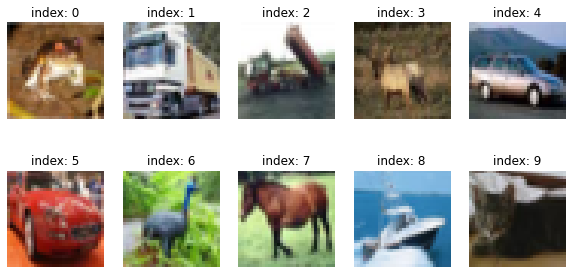

In [28]:
# 데이터 샘플 확인 10개

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1) # (row, col, index), 이미지를 2x5의 배열 형태로 보고 싶은 경우
    plt.imshow(x_train[i])
    plt.title(f'index: {i}') 
    plt.axis('off') # 불필요한 축을 지워서 깔끔하게 보이게
plt.show()

In [29]:
# CNN은 높이, 너비, 채널의 3차원 구조를 입력으로 받기 때문에, 데이터의 형태를 (데이터 개수, 높이, 너비, 채널)이어야 함
# label(레이블된 y데이터)을 categorical을 활용해 변환
#  => one-hot encoding 형태로 변환, 다중 클래스 분류 문제에서 각 클래스를 이진 벡터로 변환하여 모델이 학습하기 쉽도록 만듦

X_train = x_train 
X_test = x_test
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print("X_train.shape:", X_train.shape)  # MNIST 데이터셋은 32x32 크기의 컬러 이미지로 구성
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)  # (데이터 개수, 클래스 개수) 0~9까지 10개의 클래스
print("y_test.shape",y_test.shape)

X_train.shape: (50000, 32, 32, 3)
X_test.shape: (10000, 32, 32, 3)
y_train.shape: (50000, 10)
y_test.shape (10000, 10)


In [30]:
# scikit-learn에 내장되어 있는 train_test_split으로 train data와 validation data를 나누기

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2)

print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)

X_train.shape: (40000, 32, 32, 3)
X_val.shape: (10000, 32, 32, 3)
y_train.shape: (40000, 10)
y_val.shape: (10000, 10)


In [32]:
# 하이퍼파라미터 튜닝(성능을 최대화하는 최적의 값)을 위한 알고리즘 클래스 만들기

class DeepTuner(kt.Tuner):
    
    # "run_trial 함수"의 인자로는
    # => trial (튜닝 실험 객체), X (학습 데이터), y (레이블 데이터), validation_data (검증 데이터), **fit_kwargs (학습 함수에 전달될 추가 인자들)
   
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        model = self.hypermodel.build(trial.hyperparameters)
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(
            'batch_size', [16, 32]), **fit_kwargs)  # [16, 32]는 하이퍼파라미터 'batch_size'의 후보값

        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        
        # 모델의 메트릭 이름과 해당 메트릭의 평가 점수를 딕셔너리 형태로 반환
        return {name: value for name, value in zip(model.metrics_names, eval_scores)} 

In [33]:
# "함수 build_model": Keras Tuner를 사용하여 하이퍼파라미터 튜닝을 위한 모델 아키텍처를 정의

def build_model(hp):
    model = tf.keras.Sequential()  # 여러 레이어를 선형으로 연결한 신경망
    model.add(tf.keras.Input(shape = X_train.shape[1:], name = 'inputs')) #  입력의 형태는 X_train의 형태와 일치하도록 설정하며, 이름을 'inputs'로 지정
   
    # 검색공간은 정수로, 최소 1개에서 최대 10개의 layer를 쌓을 수 있게 설정
    #  layer는 conv2D인데 kernel_size는 (3,3)이며 차원수는 최소 32에서 최대 128
    
    for i in range(hp.Int('num_layers', min_value=1, max_value=10)):
              model.add(tf.keras.layers.Conv2D(hp.Int(
                  'units_{i}'.format(i=i), min_value=32, max_value=128, step=5), (3,3),activation='relu')) 
    
    model.add(tf.keras.layers.Flatten()) # Flatten 레이어를 추가하여 Convolutional 레이어의 출력을 1차원 벡터로 펼침
    
    # 검색공간은 정수로, 최소 1개에서 3개의 layer를 쌓을 수 있게 설정했지만
    # Dense Layer의 경우 나올 수 있는 차원을 32,64,128,256중 1개를 선택하도록 만듦
    
    for i in range(hp.Int('n_connections', 1, 3)):
        model.add(tf.keras.layers.Dense(hp.Choice(f'n_nodes',
                                  values=[32,64,128, 256]), activation = 'relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax', name = 'outputs')) # 모델의 출력 레이어, 10개의 클래스
    model.compile(optimizer = 'adam',loss='categorical_crossentropy',
        metrics=['accuracy']) #  model.compile: 모델의 학습 방식을 설정하는 단계
    return model

In [34]:
project_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'), # 'accuracy'를 'max' 최대화하는 것을 목표로 설정
        max_trials=10,                             # 최대 시도 횟수는 10번으로 설정하고, 
        seed=42),                                  # 난수 시드(seed)를 42로 설정
    hypermodel=build_model,
    overwrite=True,                                # overwrite를 True로 설정하여 이전에 저장된 튜닝 결과를 덮어씀
    project_name='project_keras_tuner')

# 해당 모델 학습시간은 약 10분정도 걸립니다!
project_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Trial 10 Complete [00h 00m 48s]
accuracy: 0.4771000146865845

Best accuracy So Far: 0.574400007724762
Total elapsed time: 00h 08m 29s
INFO:tensorflow:Oracle triggered exit


In [35]:
# 가장 좋은 하이퍼파라미터를 가져온 후 => 가장 좋은 모델을 찾아내고 => 모델 확인

best_hps = project_keras_tuner.get_best_hyperparameters(num_trials=10)[0]
model = build_model(best_hps)
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_83 (Conv2D)           (None, 30, 30, 102)       2856      
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 28, 28, 42)        38598     
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 26, 26, 67)        25393     
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 24, 24, 37)        22348     
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 22, 22, 52)        17368     
_________________________________________________________________
flatten_15 (Flatten)         (None, 25168)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)             

In [36]:
# 모델 학습

model.fit(X_train, y_train, batch_size=32, epochs = 5)

Epoch 1/5
1250/1250 [==============================] - 11s 9ms/step - loss: 1.8406 - accuracy: 0.4255
Epoch 2/5
1250/1250 [==============================] - 11s 9ms/step - loss: 1.1761 - accuracy: 0.5857
Epoch 3/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.9158 - accuracy: 0.6782
Epoch 4/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.6503 - accuracy: 0.7715
Epoch 5/5
1250/1250 [==============================] - 11s 9ms/step - loss: 0.4109 - accuracy: 0.8569


In [37]:
# 모델 평가

model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 1.5938 - accuracy: 0.5844


[1.5937589406967163, 0.5843999981880188]

In [38]:
# 모델 저장

save_path = os.getenv('HOME') + '/aiffel/mlops/best_model/1'
fname = os.path.join(save_path, 'model_YH2')
model.save(fname)

INFO:tensorflow:Assets written to: /aiffel/aiffel/mlops/best_model/1/model_YH2/assets
